### Validation important connections

For each drug-disease indication subgraph, train mask to rank important connections <br>
Once ranked, delete sorted important connections and evaluate if prediction performance change. <br>
Remove ranked elements using a 10% window size with a 2% sliding increment for each evaluation step.

In [1]:
from src.cbr_trainer.query_dataloader import DataLoader
from src.cbr_trainer.rgcn_model import HeteroRGCN
from src.cbr_trainer.rgcn_model import HeteroRGCNLayer
from src.important_paths.explainer import MaskExplainer
from src.cbr_trainer.utils.dist_scr import L2Dist
from collections import *

import pandas as pd
import os
import torch
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import dgl
import torch.nn.functional as F

In [2]:
data_dir = "data/MIND/"
data_name = "MIND"
paths_file_dir = "MIND_cbr_subgraph_knn-15_branch-1000.pkl"
device =  "cuda"

In [3]:
# Initialize data loader
dataset_obj = DataLoader(data_dir, 
                         data_name, 
                         paths_file_dir)

04/30/2025 15:32:14 - INFO - root - Loading and processing graph data...
04/30/2025 15:32:41 - INFO - root - Creating node mappings...
04/30/2025 15:32:41 - INFO - root - Loading paths data...
04/30/2025 15:32:42 - INFO - root - Processing CSV data...
04/30/2025 15:32:43 - INFO - root - Processing path data...
100%|█████████| 878/878 [00:01<00:00, 749.94it/s]
04/30/2025 15:32:47 - INFO - root - Building node labels...
04/30/2025 15:32:47 - INFO - root - Building train dataset...
100%|██████████| 760/760 [06:51<00:00,  1.85it/s]
04/30/2025 15:39:39 - INFO - root - Building test dataset...
100%|██████████| 243/243 [02:39<00:00,  1.52it/s]
04/30/2025 15:42:19 - INFO - root - Building dev dataset...
100%|██████████| 116/116 [01:15<00:00,  1.53it/s]


In [5]:
model_path = 'link_prediction_results/MIND/model/'
model_name = 'best_model_MIND_021624.pth'

model_dir = os.path.join(model_path, model_name)


In [ ]:
model = torch.load(model_dir, map_location=device)
model.to(device)
model.eval()

In [7]:
from types import SimpleNamespace
args_dict = {
"lr_" :0.1,
"num_epochs": 10,
"penalty" : 1.0,
"degree_thr" :10,
"split": "train",
"alpha": 1.0,
"beta": 1.0}
args = SimpleNamespace(**args_dict)


In [8]:
nodes_mapping = dataset_obj.nodes_mapping
if args.split == "train":
        drug_dis_train = [(item["seed_entities"][0], ans) for item in dataset_obj.raw_train_data for ans in item["answer"]]
    

In [9]:
# Initialize explainer
explainer = MaskExplainer(model, device, args, args.split)

In [58]:
pdist = nn.PairwiseDistance(p=2)

def window_list(comp_g_paths, window_percentage):
    # Calculate the window size based on the percentage
    window_size = int(len(comp_g_paths) * window_percentage / 100)

    if window_size < 1:
        raise ValueError("Window size cannot be less than 1")

    i = 0
    all_window_paths = []


    while i < len(comp_g_paths) - window_size + 1:
        window = comp_g_paths[i: i + window_size]
        all_window_paths.append(window)

        # Calculate the complement list
        complement = comp_g_paths[:i] + comp_g_paths[i + window_size:]

        i += max(1, int(len(comp_g_paths) * 0.2 / 100))  #2% overlap with the next window

    return all_window_paths

def remove_top_edges (orig_pred,
                      ml_ghomo,
                      ml_ghomo_eweights,
                     homo_nids_to_hetero_nids,
                     nn_graph,
                     disease_label, 
                     dis_id,
                     nn_idx): 
    
    pdist_res = defaultdict(list)
    all_sort_res = defaultdict(list)

    sort_imp_edges = np.argsort(np.array(ml_ghomo_eweights.detach().cpu()))[::-1].tolist()

    sets = window_list(sort_imp_edges, 10)
    sets = sets[:50]

    for step in tqdm(range(len(sets))):
        # Slice the list to get the current x elements
        test_edges = sets[step]
        edge_index_dict= defaultdict(list)
        test_graph = nn_graph[0]
        
        for edge_ in (test_edges):
            src_homo, tgt_homo = ml_ghomo.edges()[0][edge_].item(), ml_ghomo.edges()[1][edge_].item()
            src_htr_label, src_htr_label_idx = homo_nids_to_hetero_nids[src_homo][0], homo_nids_to_hetero_nids[src_homo][1]
            tgt_htr_label, tgt_htr_label_idx = homo_nids_to_hetero_nids[tgt_homo][0], homo_nids_to_hetero_nids[tgt_homo][1]
            
            for src_ntype, i, tgt_ntype in test_graph.canonical_etypes:
                if src_ntype == src_htr_label and tgt_ntype == tgt_htr_label:
                    
     
                    try:
                        edge_idx = test_graph.edge_ids(src_htr_label_idx, tgt_htr_label_idx, etype = i)
                        edge_index_dict[i].append(edge_idx)
                    except: 
                        continue
                    
         
        for rel in edge_index_dict:
            test_graph = dgl.remove_edges(test_graph, torch.tensor(edge_index_dict[rel], device=test_graph.device), rel)
            
        #get distance for ans of interest 
        global_idx_map = nodes_mapping[disease_label][0][dis_id]  #global index
        local_idx_map = np.where(test_graph.nodes[disease_label][0]["_ID"].cpu() == global_idx_map)
        local_idx_map = torch.tensor(local_idx_map[0], device=device)  # Convert and move to device


        
        list_graphs = []
        list_graphs.extend([test_graph] + [i for i in nn_graph[1:]])
        
        #get distance prediction 
        dists_pred_int_top_path, pred_top_edg = explainer.model_cbr_dists(list_graphs, 
                                                                          nn_idx, 
                                                                          local_idx_map,
                                                                         "Disease",
                                                                         device)

        res = dists_pred_int_top_path[local_idx_map][0].item()

        res_sim = pdist(orig_pred, pred_top_edg)
        pdist_res[step].append(res_sim[0].item())
    
    #save results
    pdist_res_vals = [i[0] for i in pdist_res.values()]
    sort_res = np.argsort(np.array(pdist_res_vals))[::-1].tolist() #sorted index  of important paths
    # pdist_res_vals_sort  = [pdist_res_vals[i] for i in sort_res] #sort dist
    
    return sort_res, pdist_res_vals

In [59]:
all_sort_idx = defaultdict(list)
all_sort_dist = defaultdict(list)

In [ ]:
for drug_id, dis_id in tqdm(drug_dis_train):
        orig_pred,ml_ghomo,  ml_eweight_dict, ml_ghomo_eweights, ntype_hetero_nids_to_homo_nids, nn_graph, nn_idx, paths = explainer.explain(drug_id, 
                                                                                                       dis_id, 
                                                                                                       dataset_obj, 
                                                                                                       True)
        
        ml_ghomo = dgl.to_homogeneous(nn_graph[0], edata= ["eweight"])
        homo_nids_to_hetero_nids = {v: k for k, v in ntype_hetero_nids_to_homo_nids.items()}
        
        #analize removing sorted connections
        
        sort_res, pdist_res_vals_sort = remove_top_edges(orig_pred,
                                                        ml_ghomo,
                                                         ml_ghomo_eweights, 
                                                         homo_nids_to_hetero_nids,
                                                          nn_graph,
                                                          "Disease",
                                                          dis_id,
                                                          nn_idx)
        all_sort_idx[(drug_id,dis_id )].append(sort_res)
        all_sort_dist[(drug_id,dis_id )].append(pdist_res_vals_sort)

### Visualization

In [61]:
all_sort_dist_norm = defaultdict(list)

for pair in all_sort_dist: 
    norm_res = [i for i in all_sort_dist[pair]]
    
    all_sort_dist_norm[(pair)].append(norm_res)

In [62]:
dist_split = dict()
for split in range(50): 
    dist_split[split] = ([all_sort_dist_norm[i][0][0][split] for i in all_sort_dist_norm])
df = pd.DataFrame(dist_split)

04/30/2025 16:56:20 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04/30/2025 16:56:20 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04/30/2025 16:56:21 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04/30/2025 16:56:21 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


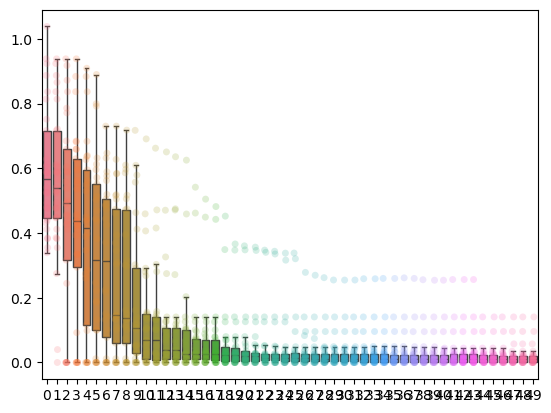

In [63]:
import seaborn as sns
g = sns.boxplot(dist_split, showfliers=False)
h = sns.stripplot(dist_split, alpha = 0.2)